## smart platform testing

## lib

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### data preprocessing

In [32]:
def get_csv_files(folder_path):
    csv_files=[]
    for files in os.listdir(folder_path):
        if files.endswith('.csv'):
            csv_files.append(os.path.join(folder_path,files))
    return csv_files

csv_files= get_csv_files('../amazon-products-dataset/versions/2')

In [33]:
# store the data in dat frame
dataframes= []
for path in csv_files:
    df = pd.read_csv(path)
    dataframes.append(df)
    
combined_df= pd.concat(dataframes,ignore_index=True)


### basic info

In [34]:
combined_df.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,Unnamed: 0
0,Puma Women's Glam WNS Sport Sandal,women's shoes,Fashion Sandals,https://m.media-amazon.com/images/I/51cVFnTFCS...,https://www.amazon.in/Puma-Womens-Glam-Lotus-S...,4.5,2,"₹1,829","₹2,999",NaN
1,Luxyfeel Fashion Sandal for Girls and Women | ...,women's shoes,Fashion Sandals,https://m.media-amazon.com/images/I/51IBSgyvAK...,https://www.amazon.in/Luxyfeel-Fashion-Sandal-...,3.8,44,₹549,"₹1,499",NaN
2,STRASSE PARIS Amazing Design Women's & Girls T...,women's shoes,Fashion Sandals,https://m.media-amazon.com/images/I/616TZINkHa...,https://www.amazon.in/STRASSE-PARIS-Transparen...,4.5,2,₹636,"₹1,899",NaN
3,Mochi Women White Wedge Heel Slip-on UK/5 EU/3...,women's shoes,Fashion Sandals,https://m.media-amazon.com/images/I/51nDP-iEI6...,https://www.amazon.in/Mochi-Women-White-Wedge-...,5.0,1,"₹1,194","₹1,990",NaN
4,Catwalk Women's Fashion UK EU US 3882,women's shoes,Fashion Sandals,https://m.media-amazon.com/images/I/712tmgiNOn...,https://www.amazon.in/Catwalk-Womens-Fashion-S...,3.7,114,₹899,"₹2,195",NaN


In [35]:
combined_df = combined_df.drop(combined_df.columns[-1], axis=1)
combined_df.drop(['name','image','link'],axis=1,inplace=True)

In [36]:
combined_df.shape

(1103170, 6)

In [37]:
combined_df=combined_df.dropna()

In [38]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 681360 entries, 0 to 1103169
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   main_category   681360 non-null  object
 1   sub_category    681360 non-null  object
 2   ratings         681360 non-null  object
 3   no_of_ratings   681360 non-null  object
 4   discount_price  681360 non-null  object
 5   actual_price    681360 non-null  object
dtypes: object(6)
memory usage: 36.4+ MB


In [39]:
combined_df.columns = (combined_df.columns.str.strip().str.lower().str.replace(" ","_"))

In [40]:
combined_df= combined_df[
    pd.to_numeric(combined_df['ratings'],errors= 'coerce').between(0,5)
]
combined_df['ratings'] = combined_df['ratings'].astype(float)

In [41]:
combined_df['no_of_ratings']= (
    combined_df['no_of_ratings'].astype(str)
    .str.replace(',','')
    .where(lambda x:x.str.fullmatch(r'\d+'))
    .astype(float)
)

In [42]:
price_pattern = r'^₹\d{1,3}(,\d{3})*$'
cols = ['discount_price','actual_price']

masked = (
    combined_df[cols]
    .astype(str)
    .apply(lambda x:x.str.match(price_pattern))
    .all(axis=1)
)

combined_df = combined_df[masked]

combined_df[cols] = (
    combined_df[cols]
    .replace({'₹':'',',':''},regex=True)
    .astype(float)
)

In [43]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 650204 entries, 0 to 1102940
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   main_category   650204 non-null  object 
 1   sub_category    650204 non-null  object 
 2   ratings         650204 non-null  float64
 3   no_of_ratings   650108 non-null  float64
 4   discount_price  650204 non-null  float64
 5   actual_price    650204 non-null  float64
dtypes: float64(4), object(2)
memory usage: 34.7+ MB


In [44]:
combined_df['main_category'].unique()

array(["women's shoes", 'car & motorbike', 'appliances',
       'grocery & gourmet foods', "kids' fashion", 'bags & luggage',
       'toys & baby products', "women's clothing", 'tv, audio & cameras',
       "men's shoes", 'sports & fitness', 'beauty & health',
       'accessories', "men's clothing", 'home & kitchen', 'music',
       'pet supplies', 'stores', 'industrial supplies',
       'home, kitchen, pets'], dtype=object)

In [45]:
combined_df['sub_category'].unique()

array(['Fashion Sandals', 'All Car & Motorbike Products',
       'Washing Machines', 'Refrigerators', 'All Grocery & Gourmet Foods',
       "Kids' Watches", 'Suitcases & Trolley Bags',
       'International Toy Store', 'Clothing', 'Camera Accessories',
       'Formal Shoes', 'Travel Accessories', 'Yoga', 'Value Bazaar',
       'Make-up', 'Personal Care Appliances', 'Coffee, Tea & Beverages',
       'Running', 'Diet & Nutrition', 'Car Electronics',
       'Gold & Diamond Jewellery', 'Beauty & Grooming',
       'Baby Bath, Skin & Grooming', 'Innerwear',
       'Health & Personal Care', 'Ballerinas', "Kids' Shoes",
       'Home Storage', 'Home Audio & Theater', 'Watches',
       'Home Entertainment Systems', 'Security Cameras', 'Travel Duffles',
       'Musical Instruments & Professional Audio', 'Kitchen & Dining',
       'Sewing & Craft Supplies', 'Strollers & Prams', 'Rucksacks',
       'All Pet Supplies', 'Toys & Games', 'Air Conditioners',
       'All Appliances', 'All Electronics', '

In [ ]:
encoder = OneHotEncoder(
    sparse_output= False,
    handle_unknown = 'ignore'
)

encoded_array = encoder.fit_transform(combined_df[['main_category']])

encoded_df =  pd.DataFrame(
    encoded_array,
    columns = encoder.get_feature_names_out(['main_category']),
    index= combined_df.index
)
combined_df = combined_df.join(encoded_df)


,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,main_category_accessories,main_category_appliances,main_category_bags & luggage,main_category_beauty & health,main_category_car & motorbike,main_category_grocery & gourmet foods,main_category_home & kitchen,"main_category_home, kitchen, pets",main_category_industrial supplies,main_category_kids' fashion,main_category_men's clothing,main_category_men's shoes,main_category_music,main_category_pet supplies,main_category_sports & fitness,main_category_stores,main_category_toys & baby products,"main_category_tv, audio & cameras",main_category_women's clothing,main_category_women's shoes
0,women's shoes,Fashion Sandals,4.5,2.0,1829.0,2999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,women's shoes,Fashion Sandals,3.8,44.0,549.0,1499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,women's shoes,Fashion Sandals,4.5,2.0,636.0,1899.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,women's shoes,Fashion Sandals,5.0,1.0,1194.0,1990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,women's shoes,Fashion Sandals,3.7,114.0,899.0,2195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102846,sports & fitness,Badminton,3.7,6.0,4698.0,6719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1102850,sports & fitness,Badminton,4.8,23.0,7548.0,10789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1102877,sports & fitness,Badminton,3.5,12.0,2448.0,3499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1102880,sports & fitness,Badminton,4.2,8.0,2698.0,3859.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
combined_df.reset_index(inplace=True,drop= True)


In [ ]:

combined_df['sub_category_te'] = np.nan
mean_rating = combined_df['ratings'].mean()

kf = KFold(n_splits = 5, shuffle= True, random_state =42)

for train_idx, val_idx in kf.split(combined_df):
    train_fold = combined_df.iloc[train_idx]
    val_fold = combined_df.iloc[val_idx]

    fold_mean = (
        train_fold.groupby('sub_category')['ratings'].mean()
    )

    combined_df.loc[val_idx,'sub_category_te'] = (
        combined_df.loc[val_idx,'sub_category']
        .map(fold_mean)
        .fillna(mean_rating)
    )

In [50]:
combined_df.drop(['main_category','sub_category'],axis=1,inplace=True)


In [51]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650204 entries, 0 to 650203
Data columns (total 25 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   ratings                                650204 non-null  float64
 1   no_of_ratings                          650108 non-null  float64
 2   discount_price                         650204 non-null  float64
 3   actual_price                           650204 non-null  float64
 4   main_category_accessories              650204 non-null  float64
 5   main_category_appliances               650204 non-null  float64
 6   main_category_bags & luggage           650204 non-null  float64
 7   main_category_beauty & health          650204 non-null  float64
 8   main_category_car & motorbike          650204 non-null  float64
 9   main_category_grocery & gourmet foods  650204 non-null  float64
 10  main_category_home & kitchen           650204 non-null  

In [52]:
combined_df.head()

,ratings,no_of_ratings,discount_price,actual_price,main_category_accessories,main_category_appliances,main_category_bags & luggage,main_category_beauty & health,main_category_car & motorbike,main_category_grocery & gourmet foods,main_category_home & kitchen,"main_category_home, kitchen, pets",main_category_industrial supplies,main_category_kids' fashion,main_category_men's clothing,main_category_men's shoes,main_category_music,main_category_pet supplies,main_category_sports & fitness,main_category_stores,main_category_toys & baby products,"main_category_tv, audio & cameras",main_category_women's clothing,main_category_women's shoes,sub_category_te
0,4.5,2.0,1829.0,2999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.548458
1,3.8,44.0,549.0,1499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.565466
2,4.5,2.0,636.0,1899.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.577666
3,5.0,1.0,1194.0,1990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.587744
4,3.7,114.0,899.0,2195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.565466


In [67]:
combined_df=combined_df.dropna()

In [71]:
#target varaible
y = combined_df['ratings'].round().astype(int)

X = combined_df.drop('ratings',axis=1)

In [72]:


num_cols = [
    'sub_category_te','no_of_ratings','discount_price','actual_price'
]

X_train, X_test, Y_train, Y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

scalar = StandardScaler()

X_train[num_cols] = scalar.fit_transform(X_train[num_cols])
X_test[num_cols] = scalar.transform(X_test[num_cols])

In [73]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='auto', max_iter= 1000)

model.fit(X_train,Y_train)

/home/nallendran/kaggle/Smart_Platform/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'auto'


In [75]:
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Accuracy :", accuracy_score(Y_test, y_pred))
print("Precision (macro):", precision_score(Y_test, y_pred, average='macro'))
print("Recall (macro)   :", recall_score(Y_test, y_pred, average='macro'))
print("F1-score (macro) :", f1_score(Y_test, y_pred, average='macro'))

# Full classification report
print(classification_report(Y_test, y_pred))


Accuracy : 0.6457061112734768
Precision (macro): 0.2842413063557286
Recall (macro)   : 0.20315829717126452
F1-score (macro) : 0.16537455304192947
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3005
           2       0.00      0.00      0.00      3827
           3       0.32      0.02      0.04     22890
           4       0.65      0.99      0.79     83977
           5       0.45      0.00      0.01     16323

    accuracy                           0.65    130022
   macro avg       0.28      0.20      0.17    130022
weighted avg       0.53      0.65      0.51    130022



/home/nallendran/kaggle/Smart_Platform/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nallendran/kaggle/Smart_Platform/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nallendran/kaggle/Smart_Platform/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

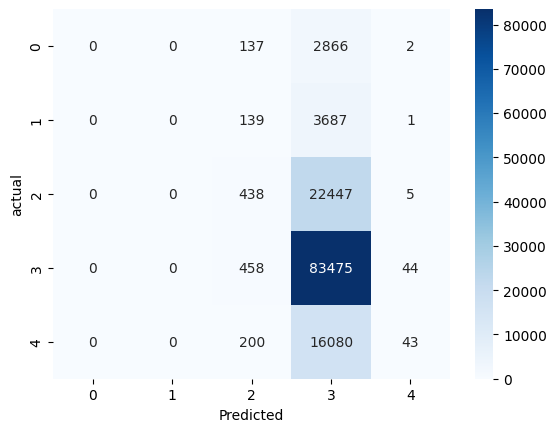

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('actual')
plt.show()